<a href="https://colab.research.google.com/github/mianzha/data-mining-/blob/main/Projet_data_mining_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toulouse (FR) Street names - Gender analysis

In [429]:
import numpy as np
import pandas as pd

In [430]:
pip install plotly.express

In [431]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

# Domain knowledge

In [432]:
# Domain specific stopwords (not relevant for prediction)
stopwords = set(["aux", "de", "des", "del", "dit", "du", "en", "et", "la", "las", "le", # mots de liaison
                 "allée", "avenue", "boulevard", "carrefour", "cité", "chemin", "impasse", "cour", "clos", # type voie
                 "enclos", "place", "passage", "pont", "quai", "rond-point", "rue", "square", "tunnel", "voie", # type voie
                 "faubourg", "route", "via", "puits", "jeu",
                 "bassin", "bois", "colline", "croix", "fontaine", "esplanade", "jardin", # environement
                 "château", "ecole", "ecoles", "espace", "loge", "moulin", "mas", "palais", "parvis", "passerelle", # environement
                 "jardins", "parc", "parking", "petit", "petite", "plan",  "tour", # environement
                 "blanc", "rouge", "roses", "vieille", "bon",
                 "deux", "quatre", # chiffres
                 "toulouse", "balma", # villes
                 "cheval", "merle", # animaux
                 "belle", "val", "mai" # prenoms from data.gouv.fr (ambigu)
                ])

In [433]:
# Prenom & genre de data.gouv.fr
url0 = "https://static.data.gouv.fr/resources/liste-de-prenoms/20141127-154433/Prenoms.csv"
names = pd.read_csv(url0, encoding = "latin", sep=";", usecols=["01_prenom", "02_genre"], index_col="01_prenom")
names = names.to_dict()['02_genre'] # mapping from name to gender, ex: Anne -> 'f' (or 'm', 'm,f')

In [434]:
# Extra women names/patterns (not in data.gouv.fr list)
for w in ["sainte", "simone"]:
    names[w] = "f"

In [435]:
# Extra men names/patterns (not in data.gouv.fr list)
for w in ["alexis", "antonin", "claude", "edouard", "emile", "etienne", "fabre", "francis",
          "hippolyte", "guilhem", "jean", "jules", "georges",  # <!> exceptions, georges sand
          "abbé", "père", "pasteur", # professions religieuse au masculin
          "colonel", "général", "maréchal", # professions militaire au masculin
          "professeur", "docteur", # autres professions au masculin
          "comte", "frères", "roi", # autres, statut social au masculin
          "saint"]:
    names[w] = "m"

# 1. Prepare dataset

In [436]:
def load_dataset(url: str):
    """
    Args:
        url: str, a link pointing a csv file, e.g., at data.montpellier3m.fr or opendata.paris.fr
    Returns:
        df: pd.DataFrame, a table containing street names as rows (along with lat, long)
    """

    # read dataset
    df = pd.read_csv(url, sep=";")

    # keep relevant columns
    df = df[['code_insee', 'commune', 'libelle', 'Geo Point']]

    # drop duplicate rows (group addresses --> average latitudes and longitudes to get coordinates of center)
    df = df.groupby(by=['code_insee', 'commune', 'libelle']).mean()

    # reset index
    df = df.reset_index()
    return df

# 2. Label street names

In [437]:
def label_street(name: str):
    """
    Args:
        name: str, street name
    Returns:
        label: int, 0 (no gender), 1 (M), 2 (F), 1.5 (uncertain or mixed H/F)
    """

    # preprocess string (lower case, remove digits and punctuation)
    name = name.lower()
    for d in "0123456789-'":
        name = name.replace(d, ' ')

    # iterate over each street words and return 1 (resp 2) if M (resp F) pattern for first name (prenom A)
    for w in name.split():
        w = w.strip() # remove extra white spaces
        if w not in stopwords and w in names:
            gender = names[w]
            if gender == 'f':
                return 2
            elif gender == 'm':
                return 1
    return 0 # no label

In [438]:
### CODE POUR TOULOUSE

# L'URL du fichier CSV
url = "https://data.toulouse-metropole.fr/explore/dataset/numero-de-rue/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true"

# Charger les données dans un DataFrame pandas
df1 = pd.read_csv(url, sep=';')

# Afficher les premières lignes du DataFrame
df1.head()


,Geo Point,Geo Shape,numero,repetition,num_long,libelle,sti,rivoli,code_postal,commune,code_insee
0,"43.52466655143368,1.3510933904857767","{""coordinates"": [[1.351093390485777, 43.524666...",19,NaN,0019,RUE ROBERT LOUIS STEVENSON,315880000174,3105880831W,31270,VILLENEUVE TOLOSANE,31588
1,"43.56930329926469,1.4089977966014127","{""coordinates"": [[1.408997796601413, 43.569303...",50,NaN,0050,RUE DE LONDRES,315554176036,3105555324Y,31100,TOULOUSE,31555
2,"43.62556081240441,1.4581329402854533","{""coordinates"": [[1.458132940285453, 43.625560...",22,NaN,0022,RUE DE LA VIERGE,315557238442,3105558864W,31500,TOULOUSE,31555
3,"43.69135851593371,1.4155960129848741","{""coordinates"": [[1.415596012984874, 43.691358...",5,NaN,0005,RUE SAINT REMY DE PROVENCE,314670000111,3104670426G,31140,SAINT ALBAN,31467
4,"43.605201288103174,1.4596209828168392","{""coordinates"": [[1.459620982816839, 43.605201...",11,NaN,0011,RUE DE LA PROVIDENCE,315555625620,3105557172G,31500,TOULOUSE,31555


In [439]:
df = df1

In [440]:
df["long"] = df['Geo Point'].str.split(",", expand = True)[1].astype(float)
df["lat"] = df['Geo Point'].str.split(",", expand = True)[0].astype(float)

In [441]:
###Keep columns and drop duplicates
df = df[['code_insee', 'commune', 'libelle', 'code_postal','long', 'lat']]

df = df.groupby(by=['code_insee', 'commune','code_postal', 'libelle']).mean()

df = df.reset_index()

In [442]:
df.head()
print(df.shape)

(8638, 6)


In [443]:
df.dtypes

code_insee       int64
commune         object
code_postal      int64
libelle         object
long           float64
lat            float64
dtype: object

In [444]:
# Test on Toulouse (FR) street names
df["label"] = df['libelle'].apply(label_street)
df.head()

,code_insee,commune,code_postal,libelle,long,lat,label
0,31003,AIGREFEUILLE,31280,ALLEE DES FENAISONS,1.582288,43.568279,0
1,31003,AIGREFEUILLE,31280,ALLEE DES MOISSONS,1.583696,43.567516,0
2,31003,AIGREFEUILLE,31280,ALLEE DES PYRENEES,1.586720,43.565934,0
3,31003,AIGREFEUILLE,31280,ALLEE DES VENDANGES,1.586880,43.567017,0
4,31003,AIGREFEUILLE,31280,ALLEE DU MONT VALLIER,1.585248,43.566446,0


# 3. Analysis

## 3.1 Names distribution / language model

In [445]:
def get_sorted_vocab(corpus):
    """
    Args:
        corpus: list of str
    Returns:
        vocab: list of str, words in corpus
        counts: list of int, word counts
    """

    # save word counts as a dictionnary
    counts_dict = {}
    for name in corpus:
        for w in name.split():
            w = w.lower().strip()
            if w not in stopwords and len(w)>0:
                if w in counts_dict:
                    counts_dict[w] +=1
                else:
                    counts_dict[w] =1

    # sort vocabulary by counts
    names = np.array(list(counts_dict.keys()))
    counts = np.array(list(counts_dict.values()))
    sorted_idx = np.argsort(counts)[::-1]
    return names[sorted_idx], counts[sorted_idx], counts_dict

In [446]:
# get vocabulary and word counts
corpus = df['libelle'].values
vocab, counts, counts_dict = get_sorted_vocab(corpus)
print('{} words found'.format(len(counts)))
print(' {} words occur 2+ times (total counts {})'.format(len([c for c in counts if c>1]), sum([c for c in counts if c>1])))
print(" Louis in vocab:", "louis" in vocab) # test if name in vocab

5207 words found
 1882 words occur 2+ times (total counts 10234)
 Louis in vocab: True


In [447]:
# inspect data (2+ occurence and not labeled as masculin or feminin)
#for i in range(len(vocab)):
#    if counts[i]>1 and label_street(vocab[i]) == 0:
#        print(vocab[i], counts[i])

### 3.1.1 Femmes vs Homme names dans le top 50 et top 100

In [448]:
def print_stats_topk(k: int = 100):
    sorted_labels = [label_street(w) for w in vocab if label_street(w) in [1.0, 2.0]]
    topk_m = len([l for l in sorted_labels[:k] if l == 1.0])
    topk_f = len([l for l in sorted_labels[:k] if l == 2.0])
    ratio_topk = 100*topk_f/(topk_m+topk_f)
    print("Top{} names 'F' = {} vs. 'M' = {} ({:.1f}% representativité)".format(k, topk_f, topk_m, ratio_topk))

In [449]:
print_stats_topk(k=50)
print_stats_topk(k=100)

Top50 names 'F' = 4 vs. 'M' = 46 (8.0% representativité)
Top100 names 'F' = 17 vs. 'M' = 83 (17.0% representativité)


### 3.1.2 Word distribution and gender bias

In [450]:
# plot power law, long tail distribution and bias (color blue M, red W, gray No Label)
def plot_word_distr(offset: int = 0, limit: int = 50):
    plt.figure(1, figsize=(15,5))
    color = {0: "gray", 1: "blue", 2: "red"}
    colors = [color[label_street(w)] for w in vocab[offset:offset+limit]]
    plt.scatter(np.arange(limit), counts[offset:offset+limit], c=colors)
    plt.plot(counts[offset:offset+limit], color="gray", linestyle='dashed')
    plt.xticks(np.arange(limit), vocab[offset:offset+limit], rotation=45)
    for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
        ticklabel.set_color(tickcolor)
    plt.ylabel("counts")
    plt.title("Toulouse (FR) - Common street names sorted by counts ({}-{})".format(offset,offset+limit))
    plt.show()

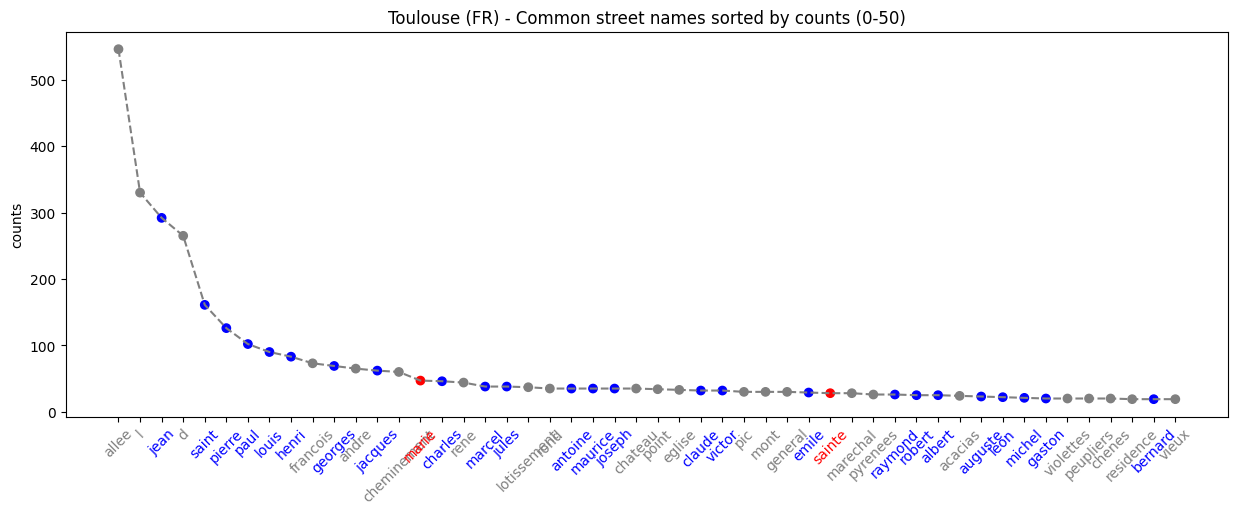

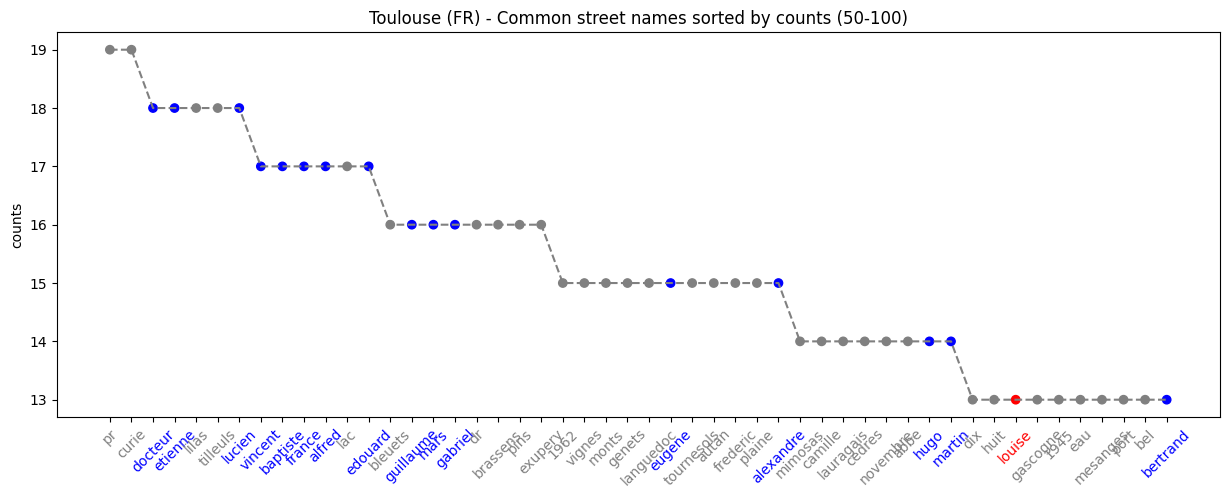

In [451]:
plot_word_distr(offset=0, limit=50)
plot_word_distr(offset=50, limit=50)

## 3.2 Gender bias - Street statistics

In [452]:
print(len(df), 'streets in Toulouse')

8638 streets in Toulouse


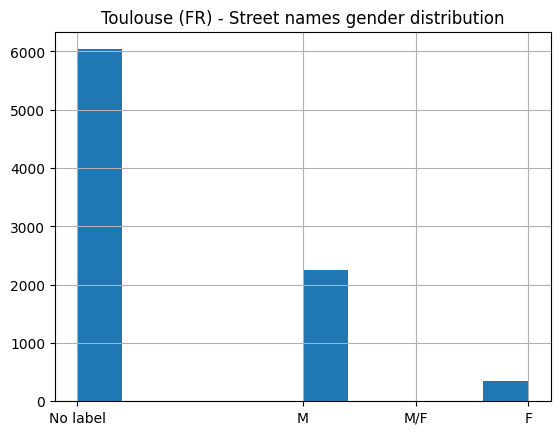

In [453]:
 #plot distribution (street names gender distribution)
df["label"].hist()
plt.title("Toulouse (FR) - Street names gender distribution")
plt.xticks([0,1,1.5,2], ["No label", "M", "M/F", "F"])
plt.show()

### 3.2.1 Rues portant des noms de Femme vs Homme

Note: Statistique sensible à l'algorithme de classification

In [454]:
n_street_f = len(df[df["label"]==2]) # ex: Square Edith Piaf
n_street_m = len(df[df["label"]==1]) # ex: Boulevard Paul Valéry
ratio_f = 100*n_street_f/(n_street_m + n_street_f)

In [455]:
print("Street 'F' = {} vs. 'M' = {} ({:.1f}% representativité)".format(n_street_f, n_street_m, ratio_f))

Street 'F' = 348 vs. 'M' = 2252 (13.4% representativité)


### 3.2.2 Rues nommées Sainte vs. Saint ...

Solution la plus simple pour calculer le biais dans une commune / métropole. Limite: High variance estimator (low n sample)

In [456]:
n_occurence_ste = counts_dict["sainte"] # ex: 'Sainte Genevieve'
n_occurence_st = counts_dict["saint"] # ex: 'Saint Pierre'
ratio_ste = 100*n_occurence_ste/(n_occurence_st+n_occurence_ste)

In [457]:
print("Occurence 'Ste' = {} vs. 'St' = {} ({:.1f}% representativité)".format(n_occurence_ste, n_occurence_st, ratio_ste))

Occurence 'Ste' = 28 vs. 'St' = 161 (14.8% representativité)


## 3.3 Analyse par type de voie

### 3.3.1 Representation féminine par voie

In [458]:
# distribution par type de voie (square, avenue, boulevard...)
types_de_voie = ["allée", "avenue", "boulevard", "carrefour", "cité", "chemin", "impasse", # type voie
                 "place", "passage", "pont", "quai", "rond-point", "rue", "square", # type voie
                 "fontaine", "esplanade", "espace", "loge", # environement
                 "parvis", "passerelle", "jardins", "parc",
                ]

df["voie_type"] = "autre"
for v in types_de_voie:
    df.loc[df["libelle"].str.lower().str.contains(v+" "), "voie_type"] = v

In [459]:
df["F"] = 0
df["M"] = 0
df.loc[df["label"].astype(int)==2, "F"] = 1
df.loc[df["label"].astype(int)==1, "M"] = 1

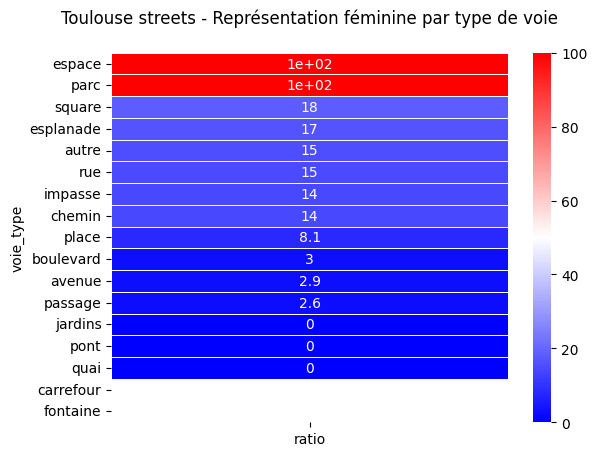

In [460]:
df_by_type = df[["voie_type", "F", "M"]].groupby(["voie_type"]).sum()
df_by_type["ratio"] = 100*df_by_type["F"]/(df_by_type["F"]+df_by_type["M"])
df_by_type = df_by_type.sort_values(["ratio"], ascending=False)

# plot representation by type of voie
sns.heatmap(df_by_type[["ratio"]], cmap='bwr', linewidths=0.5, annot=True)
plt.title("Toulouse streets - Représentation féminine par type de voie\n")
plt.show()

### 3.3.2 Analyse du genre (M/F/None) par type de voie

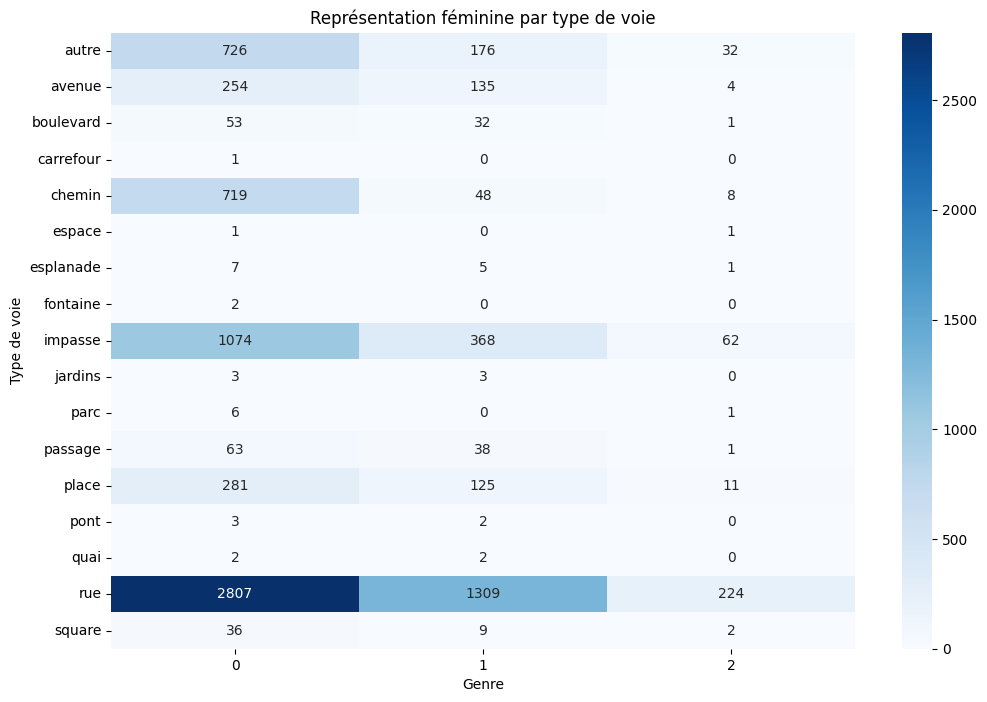

In [461]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.groupby(['voie_type', 'label']).size().unstack().fillna(0), cmap='Blues', annot=True, fmt='g')
plt.title("Représentation féminine par type de voie")
plt.xlabel("Genre")
plt.ylabel("Type de voie")
plt.show()

### 3.3.3 Analyse du genre (Masculin/Féminin) par commune

<Figure size 1600x1000 with 0 Axes>

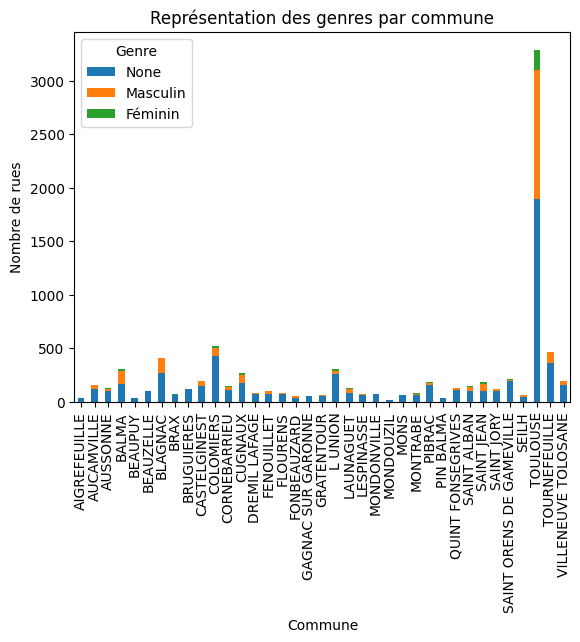

In [462]:
df_by_commune = df.groupby(['commune', 'label']).size().unstack().fillna(0)

plt.figure(figsize=(16, 10))

# Représentation des genres par commune
df_by_commune.plot(kind='bar', stacked=True)
plt.title("Représentation des genres par commune")
plt.xlabel("Commune")
plt.ylabel("Nombre de rues")
plt.legend(title="Genre", labels=['None', 'Masculin', 'Féminin'])
plt.show()


[texte du lien](https://)## 3.4 Geospatial analysis

### 3.4.1 [Toulouse](https://data.toulouse-metropole.fr/explore/dataset/numero-de-rue/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true), Occitanie

In [463]:
# rename label 0, 1, 2... for visualization
df["label"] = df["label"].astype(int)
df.loc[df["label"]==0, "label"] = "None"
df.loc[df["label"]==1, "label"] = "M"
df.loc[df["label"]==2, "label"] = "F"
#df.loc[df["label"]==1.5, "label"] = "M/F"

In [464]:
fig = px.scatter_mapbox(df, lat="lat", lon="long", zoom=12,
                        color="label",
                        color_discrete_map={
                            "None":"#000000", # black
                            "M":"#0000FF", # blue
                            "F":"#FF0000", # red
                            "M/F":"#A020F0", # violet
                        },
                        #size="type_de_voie",
                        size_max=10,
                        opacity=0.5,
                        hover_name="libelle",
                        hover_data={
                            "lat":":.3f",
                            "long":":.3f",
                            "label": True,
                            "libelle": True
                        },
                        mapbox_style = "stamen-toner", # no token required for 'open-street-map', 'carto-positron', 'stamen-toner'
                        title="{} streets - Gender analysis".format(df["commune"][0]),
                        height=750, # figure height in pixel
                       )
fig.show()

Nommons df_m1  la base issue de la classification basée sur notre fonction définie ci-haut. Elle sera utilisée dans la suite

In [465]:
df_m1 = df

## 3.4  PREDICTION DU GENRE (MML)

### 3.4.1 Préparation de la base

In [466]:
names1 = pd.read_csv(url0, encoding = "latin", sep=";", usecols=["01_prenom", "02_genre","03_langage"])
names1.head()

,01_prenom,02_genre,03_langage
0,aaliyah,f,english (modern)
1,aapeli,m,finnish
2,aapo,m,finnish
3,aaren,"m,f",english
4,aarne,m,finnish


In [467]:
### De toute façon, nous entrainerons dans la suite notre modèle sur des prenoms dans les langues que nous aurons sélectionné
## Supression de NA dans la base initiale pour la variable langue
names1.dropna(subset=['03_langage'], inplace=True)

In [468]:
names1.shape

(11196, 3)

Ajout de nouveaux prenoms qui ne sont pas dans la base

In [469]:
# Prenoms féminins ( qui ne sont pas dans la base data.gouv.fr )
extra_women_names = ["sainte", "simone", "marie","anne", "sophie","elise","sylvie","isabelle","catherine","laurence","nathalie","valerie","caroline"]
extra_women_data = pd.DataFrame({"01_prenom": extra_women_names, "02_genre": "f"})

# Prenoms masculins ( qui ne sont pas dans la base data.gouv.fr )
extra_men_names = ["alexis", "antonin", "claude", "edouard", "etienne", "fabre", "francis",
          "hippolyte", "guilhem", "jean", "jules", "georges",
          "abbé", "père", "pasteur",
          "colonel", "général", "maréchal",
          "professeur", "docteur",
          "comte", "frères", "roi",
          "saint", "victor","hugo", "charles", "gaulle", "louis", 'Sébastien','eric',
                "antoine", "foch","pierre","françois","luc","philippe","michel","david","augustin","olivier","emmanuel","jacques","albert","paul","pascal"]
extra_men_data = pd.DataFrame({"01_prenom": extra_men_names, "02_genre": "m"})

# Concaténer les deux DataFrames pour créer la seconde base
extra_data = pd.concat([extra_women_data, extra_men_data], ignore_index=True)
# Fusionner avec names1
data = pd.concat([names1, extra_data], ignore_index=True)

# Suppression des apostrophes des prénoms
data['01_prenom'] = data['01_prenom'].str.replace("'", "")
# Supprimer les lignes où 'prenom' est identique mais 'label' est différent
data.drop_duplicates(subset=['01_prenom'], keep=False, inplace=True)

# Suppression du contenu entre parenthèses dans '01_prenom' ainsi que les parenthèses elles-mêmes, puis supprimer les espaces en début et en fin de chaîne
data['01_prenom'] = data['01_prenom'].str.replace(r'\(.*\)', '', regex=True).str.strip()

### Suppression des différents accents sur le prénom
def supprimer_accents(chaine):
    # Vérifier si la valeur est de type float
    if isinstance(chaine, float):
        return chaine

    accents = {'a': 'àáâãäå', 'e': 'èéêë', 'i': 'ìíîï', 'o': 'òóôõö', 'u': 'ùúûü'}

    for lettre, accent in accents.items():
        for char in accent:
            chaine = chaine.replace(char, lettre)

    # Cas spécifique pour "frères"
    chaine = chaine.replace("è", "e").replace("ê", "e")

    return chaine

# Appliquer la fonction supprimer_accents à la colonne "prenom"
data['01_prenom'] = data['01_prenom'].apply(supprimer_accents)

# Afficher data
print(data)


       01_prenom 02_genre        03_langage
0        aaliyah        f  english (modern)
1         aapeli        m           finnish
2           aapo        m           finnish
3          aaren      m,f           english
4          aarne        m           finnish
...          ...      ...               ...
11231        roi        m               NaN
11232      saint        m               NaN
11236     gaulle        m               NaN
11238  Sebastien        m               NaN
11241       foch        m               NaN

[11183 rows x 3 columns]


Ces nouveaux NA sont pour nos nouveaux prenoms ajouter que nous pouvons renommer comme langue french, autres. Celà sera necessaire dans la suite lors de la sélection des langues à retenir

In [470]:
# Remplacer les valeurs manquantes dans la colonne 'langue' par la modalité 'french, autres'
data['03_langage'].fillna('french, autres', inplace=True)
print(data)

       01_prenom 02_genre        03_langage
0        aaliyah        f  english (modern)
1         aapeli        m           finnish
2           aapo        m           finnish
3          aaren      m,f           english
4          aarne        m           finnish
...          ...      ...               ...
11231        roi        m    french, autres
11232      saint        m    french, autres
11236     gaulle        m    french, autres
11238  Sebastien        m    french, autres
11241       foch        m    french, autres

[11183 rows x 3 columns]


In [471]:
#### Nombre de modalités de label
modalites = data['02_genre'].unique()

print("Modalités uniques dans la colonne '02_genre':", modalites)

Modalités uniques dans la colonne '02_genre': ['f' 'm' 'm,f' 'f,m']


In [472]:
# Renommer les colonnes
data= data.rename(columns={'01_prenom': 'prenom', '02_genre': 'label', '03_langage': 'langue'})

Nous devons garder que les prenoms francais et anglais

In [473]:
# liste des modalités uniques dans la colonne "langue"
modalites_langue = data['langue'].unique()

# Affichez la liste des modalités
print("Modalités uniques dans la colonne 'langue':", modalites_langue)


Modalités uniques dans la colonne 'langue': ['english (modern)' 'finnish' 'english' 'spanish' 'english, biblical'
 'biblical' 'irish' 'arabic' 'english, jewish' 'hungarian'
 'english, french, spanish, biblical' 'danish' 'african' 'indian'
 'english, german, biblical' 'biblical (variant)'
 'english, jewish, biblical' 'french' 'ancient greek (latinized)'
 'greek mythology (latinized)' 'biblical, ancient greek (latinized)'
 'french, italian' 'german' 'swedish' 'ancient germanic, german'
 'italian, spanish, portuguese'
 'english, french, german, polish, russian, romanian, biblical' 'italian'
 'portuguese' 'german, dutch' 'italian, portuguese, spanish'
 'french, english' 'turkish' 'astronomy' 'jewish' 'italian, spanish'
 'history' 'theology' 'greek mythology' 'esperanto' 'dutch'
 'english, romanian, russian'
 'italian, spanish, portuguese, romanian, english' 'anglo-saxon'
 'ancient roman' 'roman mythology' 'welsh' 'welsh mythology'
 'ancient greek (anglicized)' 'russian' 'greek, ancient gre

In [474]:
langues_retenues = ['english (modern)', 'english', 'english, biblical', 'biblical', 'english, jewish',
                    'english, french, spanish, biblical', 'african', 'english, german, biblical',
                    'french, italian', 'ancient greek (latinized)', 'greek mythology (latinized)',
                    'english, french, german, polish, russian, romanian, biblical', 'french', 'astronomy',
                    'history', 'theology', 'english, romanian, russian', 'italian, spanish, portuguese, romanian, english',
                    'anglo-saxon', 'ancient roman', 'english, scottish', 'italian, spanish', 'english, german',
                    'english, french', 'english, italian', 'italian, german, portuguese, english',
                    'italian, spanish, portuguese', 'french, portuguese, hungarian', 'french, portuguese',
                    'french, english, german, scandinavian','french, autres']

# Sélection des lignes correspondant aux langues retenues
df= data[data['langue'].isin(langues_retenues)]
# Filtrer les lignes avec les labels 'f' ou 'm'
df = df[df['label'].isin(['f', 'm'])]
df.shape

(3893, 3)

Quelques dernières vérifications

In [475]:
# Créer un masque booléen pour les valeurs manquantes dans la colonne 'prenom'
mask_missing_values = df['prenom'].isna()

# Afficher les lignes où il y a des valeurs manquantes dans la colonne 'prenom'
rows_with_missing_values = df[mask_missing_values]
print("Lignes avec des valeurs manquantes dans la colonne 'prenom':")
print(rows_with_missing_values)


Lignes avec des valeurs manquantes dans la colonne 'prenom':
     prenom label   langue
7562    NaN     f  english


In [476]:
# Supprimer les lignes avec des valeurs manquantes dans la colonne 'prenom'
df.dropna(subset=['prenom'], inplace=True)

# Réinitialiser les index après la suppression des lignes
df.reset_index(drop=True, inplace=True)


In [477]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialiser le vectoriseur avec les lettres de l'alphabet et les combinaisons de deux lettres
vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 2), lowercase=False, vocabulary=[letter for letter in 'abcdefghijklmnopqrstuvwxyz'] + [f'{a}{b}' for a in 'abcdefghijklmnopqrstuvwxyz' for b in 'abcdefghijklmnopqrstuvwxyz'])

# Transformer les prénoms en vecteurs numériques
X = vectorizer.fit_transform(df['prenom'])

# Créer un DataFrame avec les vecteurs numériques
df_features = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Afficher les premières lignes du DataFrame résultant
df_features.head()


,a,b,c,d,e,f,g,h,i,j,...,zq,zr,zs,zt,zu,zv,zw,zx,zy,zz
0,3,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Pour la création des features , plusieurs combinaisons ont été testé. Dans un premier nous avons testé sur les 26 features obtenir à partir des 26 lettres de l'alphabet. Ensuite, nous avons ajouté une combinaison de deux lettres pour les 26 lettres et enfin une combinaison de trois lettres pour les 26 lettres. Nous retenons au final les 26 + la combinaison de deux des 26 lettres. Nous pensons que le modèle sous apprend avec le premier (seulement les 26 features) et surprend avec le dernier ( 26 + Combainaison de deux + combinaison de trois), qui est source d'overfiting.   

In [478]:

####### Sauvegarder une copie de df
df_gouv = df
df_gouv= df_gouv[['prenom', 'label']]
df_gouv.head()

,prenom,label
0,aaliyah,f
1,aaron,m
2,abaddon,m
3,abbey,f
4,abbie,f


In [479]:
# Ajouter les colonnes 'label' et 'langue' de df à df_features
df = pd.concat([df_features, df[['label', 'langue']]], axis=1)

# Convertir label en numérique
from sklearn.preprocessing import LabelEncoder
# Instancier l'encodeur de labels
label_encoder = LabelEncoder()
# Appliquer l'encodage aux labels dans votre DataFrame
df['label'] = label_encoder.fit_transform(df['label'])

# Afficher les premières lignes du DataFrame pour vérifier
df.head()


,a,b,c,d,e,f,g,h,i,j,...,zs,zt,zu,zv,zw,zx,zy,zz,label,langue
0,3,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,english (modern)
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,"english, biblical"
2,2,1,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,biblical
3,1,2,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,english
4,1,2,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,english


Arbre de décision

In [480]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Supprimer la colonne 'langue' du DataFrame
df_train = df.drop(['langue'], axis=1)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(df_train, df['label'], test_size=0.2, random_state=42)
X_train = X_train.drop('label', axis=1)
X_test = X_test.drop('label', axis=1)
# Initialiser et entraîner le modèle d'arbre de décision
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
predictions = tree_model.predict(X_test)

# Évaluer les performances du modèle
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

# Afficher les résultats
print("Précision du modèle:", accuracy)
print("\nRapport de classification:")
print(report)



Précision du modèle: 0.7458279845956355

Rapport de classification:
              precision    recall  f1-score   support

           0       0.75      0.78      0.76       412
           1       0.74      0.71      0.72       367

    accuracy                           0.75       779
   macro avg       0.75      0.74      0.74       779
weighted avg       0.75      0.75      0.75       779



Support Vector Machine

In [481]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Supprimer la colonne 'langue' du DataFrame
df_train = df.drop(['langue'], axis=1)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(df_train, df['label'], test_size=0.2, random_state=42)
X_train = X_train.drop('label', axis=1)
X_test = X_test.drop('label', axis=1)

# Initialiser et entraîner le modèle SVM
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
predictions = svm_model.predict(X_test)

# Évaluer les performances du modèle
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

# Afficher les résultats
print("Précision du modèle:", accuracy)
print("\nRapport de classification:")
print(report)


Précision du modèle: 0.8228498074454429

Rapport de classification:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       412
           1       0.85      0.76      0.80       367

    accuracy                           0.82       779
   macro avg       0.83      0.82      0.82       779
weighted avg       0.82      0.82      0.82       779



Random forest

In [482]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Supprimer la colonne 'langue' du DataFrame
df_train = df.drop(['langue'], axis=1)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(df_train, df['label'], test_size=0.2, random_state=42)

# Extraire la colonne 'label' de X_train et X_test
X_train = X_train.drop('label', axis=1)
X_test = X_test.drop('label', axis=1)

# Initialiser et entraîner le modèle de forêts aléatoires
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
predictions = rf_model.predict(X_test)

# Évaluer les performances du modèle
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

# Afficher les résultats pour le modèle de forêt aléatoire
print("Précision du modèle (Forêt aléatoire):", accuracy)
print("\nRapport de classification (Forêt aléatoire):")
print(report)

Précision du modèle (Forêt aléatoire): 0.8087291399229781

Rapport de classification (Forêt aléatoire):
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       412
           1       0.82      0.75      0.79       367

    accuracy                           0.81       779
   macro avg       0.81      0.81      0.81       779
weighted avg       0.81      0.81      0.81       779



Light GBM

In [483]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Initialiser et entraîner le modèle LightGBM
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
predictions_lgbm = lgbm_model.predict(X_test)

# Évaluer les performances du modèle LightGBM
accuracy_lgbm = accuracy_score(y_test, predictions_lgbm)
report_lgbm = classification_report(y_test, predictions_lgbm)

# Afficher les résultats pour le modèle LightGBM
print("Précision du modèle (LightGBM):", accuracy_lgbm)
print("\nRapport de classification (LightGBM):")
print(report_lgbm)


[LightGBM] [Info] Number of positive: 1416, number of negative: 1697
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 3113, number of used features: 198
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.454867 -> initscore=-0.181026
[LightGBM] [Info] Start training from score -0.181026
Précision du modèle (LightGBM): 0.8138639281129654

Rapport de classification (LightGBM):
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       412
           1       0.82      0.77      0.80       367

    accuracy                           0.81       779
   macro avg       0.82      0.81      0.81       779
weighted avg       0.81      0.81      0.81       779



NOTE: Nous pouvons constater que les performances obtenus pour les différentes méthodes sont moins bonnes. Pour améliorer cette performance, dans la suite, nous explorerons d'autres pistes. Nous pouvons oberver que lq première approche de prédiction (fonction) était très précise mais faible. Cette sous -échantillon de prédiction (2600 observations) peut être ajouté la base de prenom du gouverment pour augmenter la capacité d'apprentissage. Une autre piste serait plutôt d'entrainer le modèle sur ce sous - échantillon et de prédire sur l'autre sous l'échantillon non prédit (None) avec la fonction. Nous analyserons ces deux approches dans la suite et retiendrons celle qui donne la meilleure porformance avec nos différents méthodes.

## Crétation de la sous base (F/M) de Toulouse et de la base fusionnée avec data_gouv

In [484]:
import pandas as pd
import re
# Créer une expression régulière pour correspondre aux types de rue courants
street_types_regex = r'\b(RUE|AVENUE|STREET|de|DE|DU|DES|LE|le|la|LA|route|IMPASSE|ALLEE|CHEMIN|PLACE|PASSAGE|VOIE|SQUARE|des|chemin|ROAD|BOULEVARD|AV|ST|Rd)\b'
# Supprimer ces types de rue de la colonne 'libelle' et les convertir en minuscules
df_m1['cleaned_libelle'] = df_m1['libelle'].apply(lambda x: re.sub(street_types_regex, '', x, flags=re.IGNORECASE).strip().lower())

# Conserver uniquement le premier mot
df_m1['cleaned_libelle'] = df_m1['cleaned_libelle'].apply(lambda x: x.split()[0] if len(x.split()) >= 2 else x)
# Supprimer les lignes avec des valeurs NaN dans la colonne 'cleaned_libelle'
df_m1 = df_m1.dropna(subset=['cleaned_libelle'])
# Renommer la colonne 'cleaned_libelle' en 'prenom'
df_m1 = df_m1.rename(columns={'cleaned_libelle': 'prenom'})
## une copie
df_toulouse = df_m1

df_toulouse.head()

,code_insee,commune,code_postal,libelle,long,lat,label,voie_type,F,M,prenom
0,31003,AIGREFEUILLE,31280,ALLEE DES FENAISONS,1.582288,43.568279,None,autre,0,0,fenaisons
1,31003,AIGREFEUILLE,31280,ALLEE DES MOISSONS,1.583696,43.567516,None,autre,0,0,moissons
2,31003,AIGREFEUILLE,31280,ALLEE DES PYRENEES,1.586720,43.565934,None,autre,0,0,pyrenees
3,31003,AIGREFEUILLE,31280,ALLEE DES VENDANGES,1.586880,43.567017,None,autre,0,0,vendanges
4,31003,AIGREFEUILLE,31280,ALLEE DU MONT VALLIER,1.585248,43.566446,None,autre,0,0,mont


In [485]:
### Créations la sous la base sub_df_m1 qui contient uniquement les lignes où label = M ou F
sub_df_m1 = df_m1[df_m1['label'].isin(['M', 'F'])]

# les premières lignes
print(sub_df_m1.head())
sub_df_m1.shape

    code_insee     commune  code_postal                 libelle      long  \
40       31022  AUCAMVILLE        31140       CHEMIN ANNE SALLE  1.427988   
41       31022  AUCAMVILLE        31140  CHEMIN AUGUSTE GRATIAN  1.415427   
56       31022  AUCAMVILLE        31140          CHEMIN LAURENT  1.423264   
59       31022  AUCAMVILLE        31140    IMPASSE ALBERT CAMUS  1.415320   
60       31022  AUCAMVILLE        31140  IMPASSE AUGUSTE RENOIR  1.412394   

          lat label voie_type  F  M   prenom  
40  43.662825     F    chemin  1  0     anne  
41  43.669173     M    chemin  0  1  auguste  
56  43.665419     M    chemin  0  1  laurent  
59  43.680955     M   impasse  0  1   albert  
60  43.679818     M   impasse  0  1  auguste  


(2600, 11)

Traitement sur la sous base de Toulouse et création des features pour la préidction

In [486]:
# Convertir label en numérique de la base data_gouv pour la fusion
from sklearn.preprocessing import LabelEncoder
# Instancier l'encodeur de labels
label_encoder = LabelEncoder()
# Appliquer l'encodage aux labels dans votre DataFrame
df_gouv['label'] = label_encoder.fit_transform(df_gouv['label'])
#Transformer la colonne label en numérique
# Dictionnaire de mapping
label_mapping_0 = {'F': 0, 'M': 1}

# Appliquer le mapping à la colonne label
sub_df_m1['label'] = sub_df_m1['label'].map(label_mapping_0)
# Copie de sub_df_m1 pour l'analyse après prédiction
df1 = sub_df_m1

<ipython-input-486-f0acbb098fa1>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [487]:
# Sélectionner les colonnes 'prenom' et 'label'
sub_df_m1 = sub_df_m1[['prenom', 'label']]
# deuxième Copie de sub_df_m1
sub_df1 = sub_df_m1
# Réinitialiser l'index pour sub_df1
sub_df1= sub_df1.reset_index(drop=True)
# Réinitialiser l'index pour sub_df1
df_gouv= df_gouv.reset_index(drop=True)
# Concaténer les deux DataFrames horizontalement
combined_df = pd.concat([df_gouv, sub_df1], ignore_index=True)
# Supprimer les observations identiques basées sur toutes les colonnes
combined_df = combined_df.drop_duplicates()
combined_df.head()

,prenom,label
0,aaliyah,0
1,aaron,1
2,abaddon,1
3,abbey,0
4,abbie,0


In [488]:


# Initialiser le vectoriseur avec les lettres de l'alphabet et les combinaisons de deux lettres
vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 2), lowercase=False, vocabulary=[letter for letter in 'abcdefghijklmnopqrstuvwxyz'] + [f'{a}{b}' for a in 'abcdefghijklmnopqrstuvwxyz' for b in 'abcdefghijklmnopqrstuvwxyz'])

# Transformer les derniers mots en vecteurs numériques
X = vectorizer.fit_transform(combined_df['prenom'])

# Créer un DataFrame avec les vecteurs numériques
X_prenom = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
# Réinitialiser l'index pour X_prenom
X_prenom = X_prenom.reset_index(drop=True)
# Réinitialiser l'index pour combined_df
combined_df = combined_df.reset_index(drop=True)
# Ajouter la colonne 'label' à la base sub_df1_toulouse
combined_df = pd.merge(X_prenom, combined_df[['label']], left_index=True, right_index=True)

# Afficher le DataFrame résultant
print(combined_df)
print(combined_df.shape)


      a  b  c  d  e  f  g  h  i  j  ...  zr  zs  zt  zu  zv  zw  zx  zy  zz  \
0     3  0  0  0  0  0  0  1  1  0  ...   0   0   0   0   0   0   0   0   0   
1     2  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
2     2  1  0  2  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
3     1  2  0  0  1  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
4     1  2  0  0  1  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
...  .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..   
4123  0  0  0  1  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
4124  1  0  0  0  2  0  1  0  0  0  ...   0   0   0   0   0   0   0   0   0   
4125  2  0  0  0  0  1  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
4126  1  0  0  1  0  0  1  0  0  0  ...   0   0   0   0   0   0   0   0   0   
4127  0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   

      label  
0         0  
1         1  
2        

## PREDICTION

### Base combinée

 Support Vector Machine

In [489]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Supprimer les lignes avec des valeurs manquantes dans la colonne label
combined_df = combined_df.dropna(subset=['label'])

# Diviser les données en features (X) et label (y)
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser le modèle SVM
svm_model = SVC(random_state=42)

# Entraîner le modèle sur les données d'entraînement
svm_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = svm_model.predict(X_test)

# Calculer la précision du modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8123486682808717


Light GBM

In [490]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Supprimer les lignes avec des valeurs manquantes dans la colonne label
combined_df = combined_df.dropna(subset=['label'])

# Diviser les données en features (X) et label (y)
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser le modèle LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)

# Entraîner le modèle sur les données d'entraînement
lgb_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = lgb_model.predict(X_test)

# Calculer la précision du modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


[LightGBM] [Info] Number of positive: 1574, number of negative: 1728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 492
[LightGBM] [Info] Number of data points in the train set: 3302, number of used features: 208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476681 -> initscore=-0.093345
[LightGBM] [Info] Start training from score -0.093345
Accuracy: 0.7990314769975787


XGboost

In [491]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Supprimer les lignes avec des valeurs manquantes dans la colonne label
combined_df = combined_df.dropna(subset=['label'])

# Diviser les données en features (X) et label (y)
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser le modèle XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)

# Entraîner le modèle sur les données d'entraînement
xgb_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = xgb_model.predict(X_test)

# Calculer les différentes métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Afficher les résultats
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Afficher le rapport de classification
print("Classification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 0.8111380145278451
Precision: 0.8110141448813792
Recall: 0.8111380145278451
F1 Score: 0.810903810676813
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       442
           1       0.81      0.78      0.79       384

    accuracy                           0.81       826
   macro avg       0.81      0.81      0.81       826
weighted avg       0.81      0.81      0.81       826



Note: Nous pouvons constater que la combinaison des deux base détériore la performance de nos différents modèles. Qu'en est -il de la performance sur le sous -échantillon de Toulouse?

### La sous base de Toulouse

In [492]:
sub_df1_toulouse = sub_df1

In [493]:

# Initialiser le vectoriseur avec les lettres de l'alphabet et les combinaisons de deux lettres
vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 2), lowercase=False, vocabulary=[letter for letter in 'abcdefghijklmnopqrstuvwxyz'] + [f'{a}{b}' for a in 'abcdefghijklmnopqrstuvwxyz' for b in 'abcdefghijklmnopqrstuvwxyz'])

# Transformer les derniers mots en vecteurs numériques
X = vectorizer.fit_transform(sub_df1_toulouse['prenom'])

# Créer un DataFrame avec les vecteurs numériques
X_prenom = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
# Réinitialiser l'index pour X_prenom
X_prenom = X_prenom.reset_index(drop=True)
# Réinitialiser l'index pour combined_df
sub_df1_toulouse = sub_df1_toulouse.reset_index(drop=True)
# Ajouter la colonne 'label' à la base sub_df1_toulouse
sub_df1_toulouse = pd.merge(X_prenom, sub_df1_toulouse[['label']], left_index=True, right_index=True)

# Afficher le DataFrame résultant
print(sub_df1_toulouse)
print(sub_df1_toulouse.shape)


      a  b  c  d  e  f  g  h  i  j  ...  zr  zs  zt  zu  zv  zw  zx  zy  zz  \
0     1  0  0  0  1  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
1     1  0  0  0  1  0  1  0  0  0  ...   0   0   0   0   0   0   0   0   0   
2     1  0  0  0  1  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
3     1  1  0  0  1  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
4     1  0  0  0  1  0  1  0  0  0  ...   0   0   0   0   0   0   0   0   0   
...  .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..   
2595  1  0  0  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
2596  1  0  0  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
2597  1  0  0  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
2598  0  0  0  1  2  0  0  1  0  0  ...   0   0   0   0   0   0   0   0   0   
2599  0  0  1  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   

      label  
0         0  
1         1  
2        

## PREDICTION

Support Vector Machine

In [494]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Supprimer les lignes avec des valeurs manquantes dans la colonne label
sub_df1_toulouse = sub_df1_toulouse.dropna(subset=['label'])

# Diviser les données en features (X) et label (y)
X = sub_df1_toulouse.drop(columns=['label'])
y = sub_df1_toulouse['label']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser le modèle SVM
svm_model = SVC(random_state=42)

# Entraîner le modèle sur les données d'entraînement
svm_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = svm_model.predict(X_test)

# Calculer les métriques du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Afficher les métriques
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.95
Precision: 0.9509594882729211
Recall: 0.9933184855233853
F1 Score: 0.9716775599128541


XGBoost

In [495]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Supprimer les lignes avec des valeurs manquantes dans la colonne label
sub_df1_toulouse = sub_df1_toulouse.dropna(subset=['label'])

# Diviser les données en features (X) et label (y)
X = sub_df1_toulouse.drop(columns=['label'])
y = sub_df1_toulouse['label']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser le modèle XGBoost
xgb_model = XGBClassifier(random_state=42)

# Entraîner le modèle sur les données d'entraînement
xgb_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = xgb_model.predict(X_test)

# Calculer les métriques du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Afficher les métriques
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.9711538461538461
Precision: 0.9737991266375546
Recall: 0.9933184855233853
F1 Score: 0.9834619625137818


Light GBM

In [496]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Supprimer les lignes avec des valeurs manquantes dans la colonne label
sub_df1_toulouse = sub_df1_toulouse.dropna(subset=['label'])

# Diviser les données en features (X) et label (y)
X = sub_df1_toulouse.drop(columns=['label'])
y = sub_df1_toulouse['label']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser le modèle Light GBM avec des paramètres spécifiques
lgbm_model = LGBMClassifier(n_estimators=600, learning_rate=0.01, random_state=42)

# Entraîner le modèle sur les données d'entraînement
lgbm_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = lgbm_model.predict(X_test)

# Calculer les métriques du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Afficher les métriques
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


[LightGBM] [Info] Number of positive: 1803, number of negative: 277
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 301
[LightGBM] [Info] Number of data points in the train set: 2080, number of used features: 135
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.866827 -> initscore=1.873190
[LightGBM] [Info] Start training from score 1.873190
Accuracy: 0.9673076923076923
Precision: 0.9695652173913043
Recall: 0.9933184855233853
F1 Score: 0.9812981298129813


Random Forest

In [497]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Supprimer les lignes avec des valeurs manquantes dans la colonne label
sub_df1_toulouse = sub_df1_toulouse.dropna(subset=['label'])

# Diviser les données en features (X) et label (y)
X = sub_df1_toulouse.drop(columns=['label'])
y = sub_df1_toulouse['label']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser le modèle Random Forest avec le bon paramètre pour le nombre d'estimateurs (n_estimators)
rf_model = RandomForestClassifier(random_state=42, n_estimators=500)

# Entraîner le modèle sur les données d'entraînement
rf_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = rf_model.predict(X_test)

# Calculer les métriques du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Afficher les métriques
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.9653846153846154
Precision: 0.9694989106753813
Recall: 0.9910913140311804
F1 Score: 0.9801762114537446


Note: Au vu des résultats, nous retons Support Vector Machine  pour la suite.

---



## APPLICATION SUR LA BASE COMPLETE DE TOULOUSE

In [498]:
# Ajouter une colonne ID
df_toulouse['id'] = range(len(df_toulouse))
# Initialiser le vectoriseur avec les lettres de l'alphabet et les combinaisons de deux lettres
vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 2), lowercase=False, vocabulary=[letter for letter in 'abcdefghijklmnopqrstuvwxyz'] + [f'{a}{b}' for a in 'abcdefghijklmnopqrstuvwxyz' for b in 'abcdefghijklmnopqrstuvwxyz'])

# Transformer les derniers mots en vecteurs numériques
X_dernier_mot = vectorizer.fit_transform(df_toulouse['prenom'])

# Créer un DataFrame avec les vecteurs numériques
df_toulouse_model = pd.DataFrame(X_dernier_mot.toarray(), columns=vectorizer.get_feature_names_out())

# Afficher les premières lignes du DataFrame résultant
df_toulouse_model.head()
print(df_toulouse_model)

      a  b  c  d  e  f  g  h  i  j  ...  zq  zr  zs  zt  zu  zv  zw  zx  zy  \
0     1  0  0  0  1  1  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
1     0  0  0  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
2     0  0  0  0  3  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
3     1  0  0  1  2  0  1  0  0  0  ...   0   0   0   0   0   0   0   0   0   
4     0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
...  .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..   
8633  1  0  0  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
8634  0  0  0  1  2  0  0  1  0  0  ...   0   0   0   0   0   0   0   0   0   
8635  0  0  1  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
8636  1  0  0  0  1  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
8637  0  0  0  0  1  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   

      zz  
0      0  
1      0  
2      0  
3      

In [499]:
## Prdiction avec XGboost pour l'apprentissage avec la sous base
predictions_toulouse_svm = xgb_model.predict(df_toulouse_model)

# Ajout des prédictions au DataFrame df_toulouse_model
df_toulouse_model['Prédiction'] = predictions_toulouse_svm

# Affichage des résultats des prédictions pour df_toulouse_model
print(df_toulouse_model)

      a  b  c  d  e  f  g  h  i  j  ...  zr  zs  zt  zu  zv  zw  zx  zy  zz  \
0     1  0  0  0  1  1  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
1     0  0  0  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
2     0  0  0  0  3  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
3     1  0  0  1  2  0  1  0  0  0  ...   0   0   0   0   0   0   0   0   0   
4     0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
...  .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..   
8633  1  0  0  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
8634  0  0  0  1  2  0  0  1  0  0  ...   0   0   0   0   0   0   0   0   0   
8635  0  0  1  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
8636  1  0  0  0  1  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
8637  0  0  0  0  1  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   

      Prédiction  
0              1  
1            

Note : Notons que nous avons testé la prédiction avec l'ensemble des modèles ci-dessous. Nous pouvons constater un problème de généralisation de nos résultats sur de nouvelles données, c'est à dire un problème d'overfiting. Bien que nous obtenons des meilleures performances pour nos différents modèles, les résultats de prédiction sur l'autre sous base de Toulouse sont mauvaises.
Par conséquent dans la suite, nous utuliserons la seconde piste c'est à
 dire l'apprentissage sur la base des prenoms du gouvernement combinée à la sous base de Toulouse obtenue à partir de la fonction dans la première partie  pour la prédiction. La méthode de XGboost était la meilleure et donc sera choisie.

In [500]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Supprimer les lignes avec des valeurs manquantes dans la colonne label
combined_df = combined_df.dropna(subset=['label'])

# Diviser les données en features (X) et label (y)
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser le modèle XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)

# Entraîner le modèle sur les données d'entraînement
xgb_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = xgb_model.predict(X_test)

# Calculer les différentes métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Afficher les résultats
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Afficher le rapport de classification
print("Classification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 0.8111380145278451
Precision: 0.8110141448813792
Recall: 0.8111380145278451
F1 Score: 0.810903810676813
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       442
           1       0.81      0.78      0.79       384

    accuracy                           0.81       826
   macro avg       0.81      0.81      0.81       826
weighted avg       0.81      0.81      0.81       826



In [501]:
## Prdiction avec SVM pour l'apprentissage avec les prenoms de data_gouv
df_toulouse_model = df_toulouse_model.drop('Prédiction', axis=1)
predictions_toulouse_svm = xgb_model.predict(df_toulouse_model)

# Ajout des prédictions au DataFrame df_toulouse_model
df_toulouse_model['Prédiction'] = predictions_toulouse_svm

# Affichage des résultats des prédictions pour df_toulouse_model
print(df_toulouse_model)

      a  b  c  d  e  f  g  h  i  j  ...  zr  zs  zt  zu  zv  zw  zx  zy  zz  \
0     1  0  0  0  1  1  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
1     0  0  0  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
2     0  0  0  0  3  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
3     1  0  0  1  2  0  1  0  0  0  ...   0   0   0   0   0   0   0   0   0   
4     0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
...  .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..   
8633  1  0  0  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
8634  0  0  0  1  2  0  0  1  0  0  ...   0   0   0   0   0   0   0   0   0   
8635  0  0  1  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
8636  1  0  0  0  1  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
8637  0  0  0  0  1  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   

      Prédiction  
0              1  
1            

In [502]:
df1.head()

,code_insee,commune,code_postal,libelle,long,lat,label,voie_type,F,M,prenom
40,31022,AUCAMVILLE,31140,CHEMIN ANNE SALLE,1.427988,43.662825,0,chemin,1,0,anne
41,31022,AUCAMVILLE,31140,CHEMIN AUGUSTE GRATIAN,1.415427,43.669173,1,chemin,0,1,auguste
56,31022,AUCAMVILLE,31140,CHEMIN LAURENT,1.423264,43.665419,1,chemin,0,1,laurent
59,31022,AUCAMVILLE,31140,IMPASSE ALBERT CAMUS,1.415320,43.680955,1,impasse,0,1,albert
60,31022,AUCAMVILLE,31140,IMPASSE AUGUSTE RENOIR,1.412394,43.679818,1,impasse,0,1,auguste


In [503]:
# Ajouter une colonne ID
df_toulouse_model['id'] = range(len(df_toulouse_model))
### FUsion avec la base initiale
df_toulouse_resultat_svm=pd.merge(df_toulouse, df_toulouse_model, on='id', how='left')
# Remplacer toutes les valeurs 0 dans la colonne 'Prédiction' par 2
df_toulouse_resultat_svm['Prédiction'] = df_toulouse_resultat_svm['Prédiction'].replace(0, 2)
##homme et femme
df1[(df1['label'] == 1) | (df1['label'] == 2)]
resultat_m1=df1[(df1['label']==1)|(df1['label']==2)]

# Imprimer le DataFrame fusionné pour vérifier les résultats
print(df_toulouse_resultat_svm)


      code_insee              commune  code_postal                libelle  \
0          31003         AIGREFEUILLE        31280    ALLEE DES FENAISONS   
1          31003         AIGREFEUILLE        31280     ALLEE DES MOISSONS   
2          31003         AIGREFEUILLE        31280     ALLEE DES PYRENEES   
3          31003         AIGREFEUILLE        31280    ALLEE DES VENDANGES   
4          31003         AIGREFEUILLE        31280  ALLEE DU MONT VALLIER   
...          ...                  ...          ...                    ...   
8633       31588  VILLENEUVE TOLOSANE        31270       RUE SAINT PERIER   
8634       31588  VILLENEUVE TOLOSANE        31270     RUE THEODORE MONOD   
8635       31588  VILLENEUVE TOLOSANE        31270        RUE VICTOR HUGO   
8636       31588  VILLENEUVE TOLOSANE        31270           RUE VOLTAIRE   
8637       31588  VILLENEUVE TOLOSANE        31270  VIEUX CHEMIN DE MURET   

          long        lat label voie_type  F  M  ... zr  zs  zt  zu  zv  zw

In [504]:
print(resultat_m1)

      code_insee              commune  code_postal                   libelle  \
41         31022           AUCAMVILLE        31140    CHEMIN AUGUSTE GRATIAN   
56         31022           AUCAMVILLE        31140            CHEMIN LAURENT   
59         31022           AUCAMVILLE        31140      IMPASSE ALBERT CAMUS   
60         31022           AUCAMVILLE        31140    IMPASSE AUGUSTE RENOIR   
64         31022           AUCAMVILLE        31140  IMPASSE CHARLES PERRAULT   
...          ...                  ...          ...                       ...   
8631       31588  VILLENEUVE TOLOSANE        31270           RUE SAINT AUBIN   
8632       31588  VILLENEUVE TOLOSANE        31270         RUE SAINT LAURENT   
8633       31588  VILLENEUVE TOLOSANE        31270          RUE SAINT PERIER   
8634       31588  VILLENEUVE TOLOSANE        31270        RUE THEODORE MONOD   
8635       31588  VILLENEUVE TOLOSANE        31270           RUE VICTOR HUGO   

          long        lat  label voie_t

In [505]:
### Fusion complète avec les variables initailes
import pandas as pd
df_merged = pd.merge(resultat_m1, df_toulouse_resultat_svm, on=['code_insee', 'commune', 'code_postal', 'libelle'], how='left')
# Imprimer le DataFrame fusionné pour vérifier les résultats
print(df_merged)

      code_insee              commune  code_postal                   libelle  \
0          31022           AUCAMVILLE        31140    CHEMIN AUGUSTE GRATIAN   
1          31022           AUCAMVILLE        31140            CHEMIN LAURENT   
2          31022           AUCAMVILLE        31140      IMPASSE ALBERT CAMUS   
3          31022           AUCAMVILLE        31140    IMPASSE AUGUSTE RENOIR   
4          31022           AUCAMVILLE        31140  IMPASSE CHARLES PERRAULT   
...          ...                  ...          ...                       ...   
2247       31588  VILLENEUVE TOLOSANE        31270           RUE SAINT AUBIN   
2248       31588  VILLENEUVE TOLOSANE        31270         RUE SAINT LAURENT   
2249       31588  VILLENEUVE TOLOSANE        31270          RUE SAINT PERIER   
2250       31588  VILLENEUVE TOLOSANE        31270        RUE THEODORE MONOD   
2251       31588  VILLENEUVE TOLOSANE        31270           RUE VICTOR HUGO   

        long_x      lat_x  label_x voie

In [506]:
## Sélection des colonnes
selected_columns = df_merged[['code_insee', 'commune', 'code_postal', 'libelle', 'prenom_x', 'Prédiction','label_x']]
# Calculer la proportion des valeurs égales entre les colonnes Prédiction et label
accuracy = (selected_columns['Prédiction'] == selected_columns['label_x']).mean()
print(f"La proportion des valeurs égales est : {accuracy}")




La proportion des valeurs égales est : 0.838809946714032


Nous obtenons 83,66% de bonnes prédiction ce qui n'est mauvaise dans l'ensemble.

In [507]:
# appliquons sur les observations non identifie dans la methode de fonction
resultat_m1_no_label=df_m1[df_m1['label']=="None"]
####### Base non label fusionnée
df_merged_nolabel = pd.merge(resultat_m1_no_label, df_toulouse_resultat_svm, on=['code_insee', 'commune', 'code_postal', 'libelle'], how='inner')
print(df_merged_nolabel)

      code_insee              commune  code_postal                libelle  \
0          31003         AIGREFEUILLE        31280    ALLEE DES FENAISONS   
1          31003         AIGREFEUILLE        31280     ALLEE DES MOISSONS   
2          31003         AIGREFEUILLE        31280     ALLEE DES PYRENEES   
3          31003         AIGREFEUILLE        31280    ALLEE DES VENDANGES   
4          31003         AIGREFEUILLE        31280  ALLEE DU MONT VALLIER   
...          ...                  ...          ...                    ...   
6033       31588  VILLENEUVE TOLOSANE        31270             RUE MOZART   
6034       31588  VILLENEUVE TOLOSANE        31270           RUE REGNAULT   
6035       31588  VILLENEUVE TOLOSANE        31270        RUE RENE CASSIN   
6036       31588  VILLENEUVE TOLOSANE        31270           RUE VOLTAIRE   
6037       31588  VILLENEUVE TOLOSANE        31270  VIEUX CHEMIN DE MURET   

        long_x      lat_x label_x voie_type_x  F_x  M_x  ... zr  zs  zt  zu

In [508]:
#combiner les observations identifie dans la methode de fonction (ideal) et les observations identifie dans la methode de MM
#Comme il n'y a pas de lignes en commun entre eux
#nnouveau resultats
import pandas as pd

df_merged_nolabel_1=df_merged_nolabel
resultat_m1_1=resultat_m1

# Renommer la colonne 'Prédiction' en 'genre' dans df_merged_nolabel
df_merged_nolabel_1.rename(columns={'Prédiction': 'genre'}, inplace=True)

# Renommer la colonne 'label' en 'genre' dans resultat_m1
resultat_m1_1.rename(columns={'label': 'genre'}, inplace=True)

# Fusionner les DataFrames, en choisissant les colonnes communes ainsi que les colonnes spécifiées
common_columns = list(set(df_merged_nolabel_1.columns) & set(resultat_m1_1.columns))
merged_resultat = pd.merge(df_merged_nolabel_1[common_columns],
                     resultat_m1[common_columns],
                     on=common_columns,
                     how='outer')

# Afficher le DataFrame fusionné
print(merged_resultat)
# Vérifier les valeurs uniques dans la colonne 'genre'
unique_label = merged_resultat['genre'].unique()
print("Valeurs uniques de 'genre' :", unique_label)

      code_insee                libelle  genre  code_postal  \
0          31003    ALLEE DES FENAISONS      1        31280   
1          31003     ALLEE DES MOISSONS      1        31280   
2          31003     ALLEE DES PYRENEES      2        31280   
3          31003    ALLEE DES VENDANGES      1        31280   
4          31003  ALLEE DU MONT VALLIER      1        31280   
...          ...                    ...    ...          ...   
8285       31588        RUE SAINT AUBIN      1        31270   
8286       31588      RUE SAINT LAURENT      1        31270   
8287       31588       RUE SAINT PERIER      1        31270   
8288       31588     RUE THEODORE MONOD      1        31270   
8289       31588        RUE VICTOR HUGO      1        31270   

                  commune  
0            AIGREFEUILLE  
1            AIGREFEUILLE  
2            AIGREFEUILLE  
3            AIGREFEUILLE  
4            AIGREFEUILLE  
...                   ...  
8285  VILLENEUVE TOLOSANE  
8286  VILLENEUVE TO

<ipython-input-508-95dbde5b3f84>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [509]:

print(df_toulouse_resultat_svm.shape)
df_toulouse_resultat_svm.head()

(8638, 714)


,code_insee,commune,code_postal,libelle,long,lat,label,voie_type,F,M,...,zr,zs,zt,zu,zv,zw,zx,zy,zz,Prédiction
0,31003,AIGREFEUILLE,31280,ALLEE DES FENAISONS,1.582288,43.568279,None,autre,0,0,...,0,0,0,0,0,0,0,0,0,1
1,31003,AIGREFEUILLE,31280,ALLEE DES MOISSONS,1.583696,43.567516,None,autre,0,0,...,0,0,0,0,0,0,0,0,0,1
2,31003,AIGREFEUILLE,31280,ALLEE DES PYRENEES,1.586720,43.565934,None,autre,0,0,...,0,0,0,0,0,0,0,0,0,2
3,31003,AIGREFEUILLE,31280,ALLEE DES VENDANGES,1.586880,43.567017,None,autre,0,0,...,0,0,0,0,0,0,0,0,0,1
4,31003,AIGREFEUILLE,31280,ALLEE DU MONT VALLIER,1.585248,43.566446,None,autre,0,0,...,0,0,0,0,0,0,0,0,0,1


## NOUVELLES ANALYSES COMBINANT LA FONCTION ET LA RESULTATS DE MACHINE LEARNING

In [510]:
#reconstruire le dictionnaire de nom-genre
import pandas as pd

names2 = df_toulouse_resultat_svm[['prenom', 'Prédiction']]
names2['Prédiction'] = names2['Prédiction'].replace({2: 'f', 1: 'm'})
print(names2.head())
name_df = pd.DataFrame(list(names.items()), columns=['prenom', 'genre'])
name_df.head()


      prenom Prédiction
0  fenaisons          m
1   moissons          m
2   pyrenees          f
3  vendanges          m
4       mont          m


<ipython-input-510-df8eaf648606>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,prenom,genre
0,aaliyah,f
1,aapeli,m
2,aapo,m
3,aaren,"m,f"
4,aarne,m


In [511]:
import pandas as pd

# Supposons que name_df et names2 soient vos DataFrames

# Renommer les colonnes de names2 pour correspondre aux noms de colonnes de name_df
names2 = names2.rename(columns={'prenom': 'prenom', 'Prédiction': 'genre'})

# Placer name_df en premier, suivi de names2, puis fusionner
combined_name_df = pd.concat([name_df, names2])

# Utiliser drop_duplicates pour supprimer les doublons en conservant la première occurrence (c'est-à-dire les éléments de name_df)
combined_name_df = combined_name_df.drop_duplicates(subset=['prenom'], keep='first')

# Afficher le DataFrame combiné
print(combined_name_df)

            prenom genre
0          aaliyah     f
1           aapeli     m
2             aapo     m
3            aaren   m,f
4            aarne     m
...            ...   ...
8559   maguelonnes     f
8566     boulbenes     m
8588        parets     m
8597      vanniers     f
8612  tournebroche     f

[14409 rows x 2 columns]


In [512]:
# exemple de vérification  'prenom'=='fenaisons'
fenaisons_rows = combined_name_df[combined_name_df['prenom'] == 'fenaisons']
print(fenaisons_rows)

      prenom genre
0  fenaisons     m


In [513]:
# get vocabulary and word counts
import pandas as pd
import numpy as np

def get_sorted_vocab(corpus, stopwords):
    """
    Args:
        corpus: list of str, liste des noms de rue
        stopwords: list of str, mots à exclure du décompte
    Returns:
        vocab: list of str, mots dans le corpus
        counts: list of int, comptes de mots
    """
    counts_dict = {}
    for name in corpus:
        for w in name.lower().split():
            w = w.strip()
            if w not in stopwords and len(w) > 0:
                if w in counts_dict:
                    counts_dict[w] += 1
                else:
                    counts_dict[w] = 1

    names = np.array(list(counts_dict.keys()))
    counts = np.array(list(counts_dict.values()))
    sorted_idx = np.argsort(counts)[::-1]
    return names[sorted_idx], counts[sorted_idx]

# Définir une liste de mots vides (stopwords)
stopwords = set(["aux", "de",'l','d','allee', "des", "del", "dit", "du", "en", "et", "la", "las", "le", # mots de liaison
                 "allée", "avenue", "boulevard", "carrefour", "cité", "chemin", "impasse", "cour", "clos", # type voie
                 "enclos", "place", "passage", "pont", "quai", "rond-point", "rue", "square", "tunnel", "voie", # type voie
                 "faubourg", "route", "via", "puits", "jeu",
                 "bassin", "bois", "colline", "croix", "fontaine", "esplanade", "jardin", # environement
                 "château", "ecole", "ecoles", "espace", "loge", "moulin", "mas", "palais", "parvis", "passerelle", # environement
                 "jardins", "parc", "parking", "petit", "petite", "plan",  "tour", # environement
                 "blanc", "rouge", "roses", "vieille", "bon",
                 "deux", "quatre", # chiffres
                 "toulouse", "balma", # villes
                 "cheval", "merle", # animaux
                 "belle", "val", "mai" # prenoms from data.gouv.fr (ambigu)
                ])

# Supposons que 'merged_resultat' soit votre DataFrame et qu'il contienne une colonne 'libelle'
# Convertir d'abord la colonne 'libelle' en minuscules
merged_resultat['libelle'] = merged_resultat['libelle'].str.lower()

# Utiliser la fonction pour calculer la fréquence des mots
corpus = merged_resultat['libelle'].values
vocab, counts = get_sorted_vocab(corpus, stopwords)

# Afficher les résultats
for word, count in zip(vocab, counts):
    print(f"{word}: {count}")
# Afficher le nombre total de mots uniques trouvés dans les données
print(f"{len(counts)} mots trouvés")

# Afficher le nombre de mots apparaissant 2 fois ou plus, ainsi que le total de leurs occurrences
mots_apparaissant_plusieurs_fois = [c for c in counts if c > 1]
print(f"{len(mots_apparaissant_plusieurs_fois)} mots apparaissent 2 fois ou plus (total des occurrences {sum(mots_apparaissant_plusieurs_fois)})")

# Vérifier si un mot spécifique existe dans le vocabulaire
mot_a_verifier = "louis"
print(f"{mot_a_verifier} dans le vocabulaire :", mot_a_verifier in vocab)

jean: 292
saint: 160
pierre: 126
paul: 102
louis: 90
henri: 83
francois: 72
georges: 69
andre: 63
jacques: 62
cheminement: 59
charles: 46
rene: 44
marcel: 38
jules: 38
lotissement: 37
antoine: 35
maurice: 35
chateau: 35
joseph: 35
rond: 34
point: 33
eglise: 33
victor: 32
claude: 31
mont: 30
pic: 30
general: 30
emile: 29
marechal: 28
pyrenees: 26
albert: 25
robert: 25
raymond: 25
acacias: 24
auguste: 23
leon: 22
violettes: 20
peupliers: 20
gaston: 20
chenes: 20
vieux: 19
pr: 19
bernard: 19
lucien: 18
residence: 18
etienne: 18
tilleuls: 18
docteur: 18
lilas: 18
alfred: 17
edouard: 17
lac: 17
baptiste: 17
vincent: 17
michel: 17
exupery: 16
bleuets: 16
guillaume: 16
dr: 16
brassens: 16
france: 16
gabriel: 16
mars: 16
pins: 16
1962: 15
tournesols: 15
frederic: 15
languedoc: 15
eugene: 15
alexandre: 15
autan: 15
monts: 15
vignes: 15
genets: 15
plaine: 15
novembre: 14
mimosas: 14
cedres: 14
abbe: 14
hugo: 14
camille: 14
martin: 14
lauragais: 14
eau: 13
huit: 13
tamaris: 13
1945: 13
mesanges: 

In [514]:
# Convertir les colonnes 'prenom' et 'genre' de combined_name_df en un dictionnaire
nouveaux_noms = combined_name_df.set_index('prenom')['genre'].to_dict()
# Utiliser les nouveaux_noms pour remplacer le dictionnaire existant names
names = nouveaux_noms


In [515]:
def label_street(name: str):
    """
    Args:
        name: str, street name
    Returns:
        label: int, 0 (no gender), 1 (M), 2 (F), 1.5 (uncertain or mixed H/F)
    """

    # preprocess string (lower case, remove digits and punctuation)
    name = name.lower()
    for d in "0123456789-'":
        name = name.replace(d, ' ')

    # iterate over each street words and return 1 (resp 2) if M (resp F) pattern for first name (prenom A)
    for w in name.split():
        w = w.strip() # remove extra white spaces
        if w not in stopwords and w in names:
            gender = names[w]
            if gender == 'f':
                return 2
            elif gender == 'm':
                return 1
    return 0 # no label

In [516]:
#Femmes vs Homme names dans le top 50 et top 100
def print_stats_topk(k: int = 100):
    sorted_labels = [label_street(w) for w in vocab if label_street(w) in [1.0, 2.0]]
    topk_m = len([l for l in sorted_labels[:k] if l == 1.0])
    topk_f = len([l for l in sorted_labels[:k] if l == 2.0])
    ratio_topk = 100*topk_f/(topk_m+topk_f)
    print("Top{} names 'F' = {} vs. 'M' = {} ({:.1f}% representativité)".format(k, topk_f, topk_m, ratio_topk))

print_stats_topk(k=50)
print_stats_topk(k=100)


Top50 names 'F' = 10 vs. 'M' = 40 (20.0% representativité)
Top100 names 'F' = 22 vs. 'M' = 78 (22.0% representativité)


In [517]:
# plot power law, long tail distribution and bias (color blue M, red W, gray No Label)
def plot_word_distr(offset: int = 0, limit: int = 50):
    plt.figure(1, figsize=(15,5))
    color = {0: "gray", 1: "blue", 2: "red"}
    colors = [color[label_street(w)] for w in vocab[offset:offset+limit]]
    plt.scatter(np.arange(limit), counts[offset:offset+limit], c=colors)
    plt.plot(counts[offset:offset+limit], color="gray", linestyle='dashed')
    plt.xticks(np.arange(limit), vocab[offset:offset+limit], rotation=45)
    for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
        ticklabel.set_color(tickcolor)
    plt.ylabel("counts")
    plt.title("Toulouse (FR) - Common street names sorted by counts ({}-{})".format(offset,offset+limit))
    plt.show()

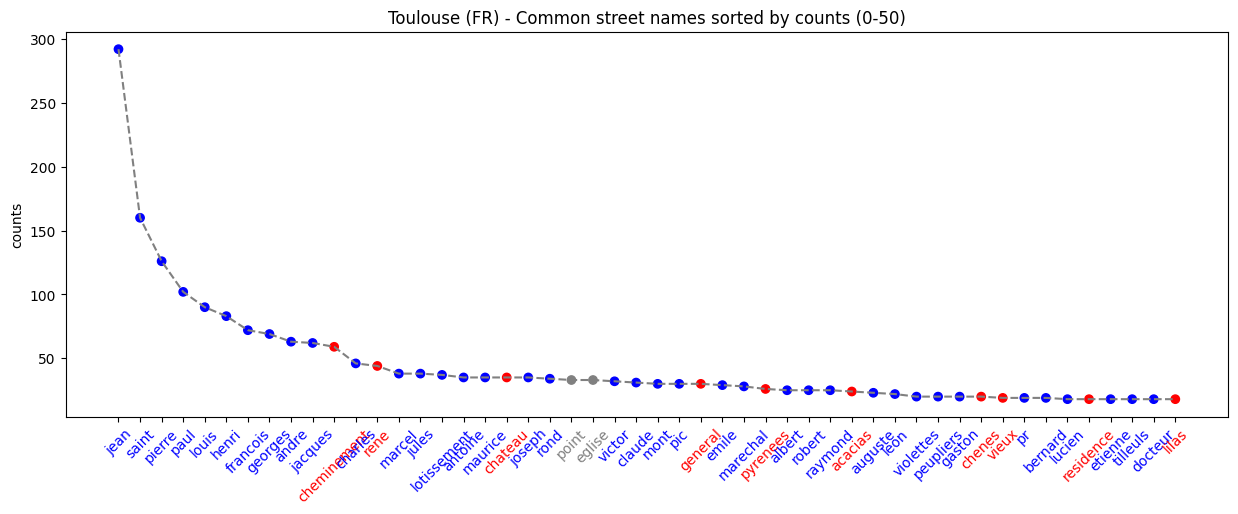

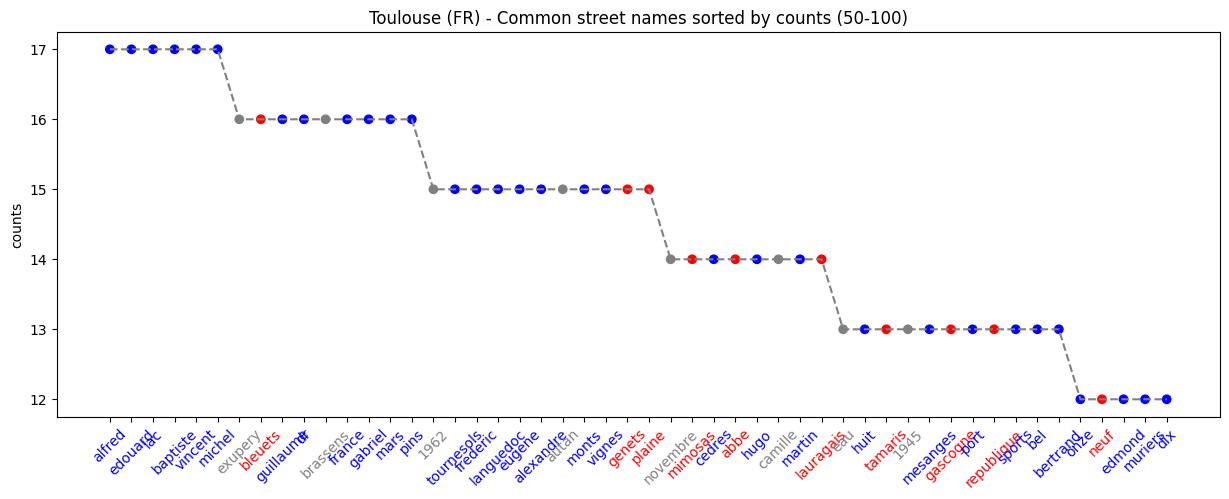

In [518]:
plot_word_distr(offset=0, limit=50)
plot_word_distr(offset=50, limit=50)

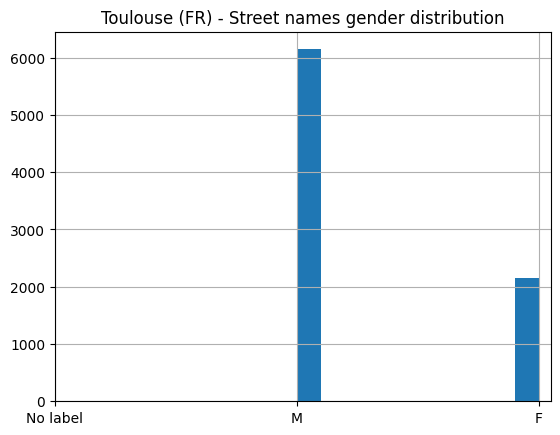

In [519]:
 #plot distribution (street names gender distribution)
merged_resultat["genre"].hist()
plt.title("Toulouse (FR) - Street names gender distribution")
plt.xticks([0,1,2], ["No label", "M", "F"])
plt.show()

### Analyse du genre par type de voie

<Figure size 1600x1000 with 0 Axes>

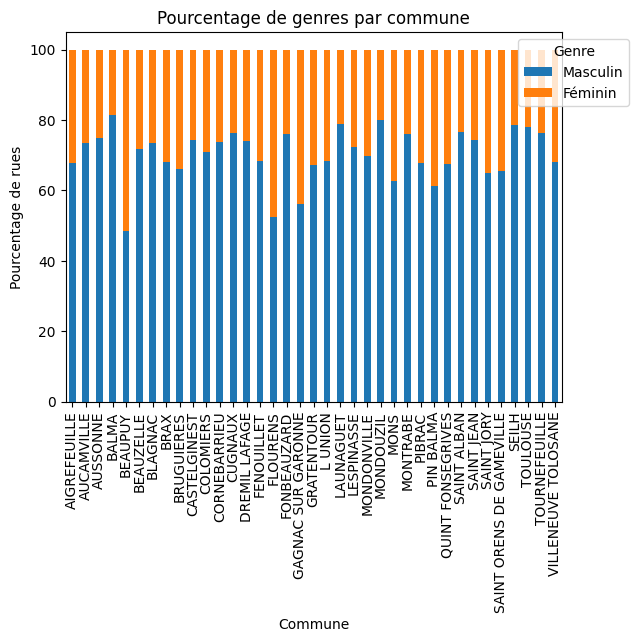

In [520]:
import matplotlib.pyplot as plt
import pandas as pd

def percentage_stack_bar_plot(df, xlabel, ylabel, title):
    # Convertir les valeurs en pourcentages
    df_percentage = df.div(df.sum(axis=1), axis=0) * 100

    # Plot
    plt.figure(figsize=(16, 10))
    df_percentage.plot(kind='bar', stacked=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title="Genre", labels=['Masculin', 'Féminin'], loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.show()

# Utilisation de la fonction pour le DataFrame merged_resultat_by_commune
percentage_stack_bar_plot(merged_resultat_by_commune, "Commune", "Pourcentage de rues", "Pourcentage de genres par commune")


Note: Nous résultats montrent toujours une discrimisation envers les noms de rues féminin dans la métropole de toulouse. Cette discrimination semble plus faible dans les petites communes, confirmant les résultats obtenus dans la littérature sur l'analyse des noms des rue.